In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

## Overview of Polymer dataset

In [23]:
polymer_df = pd.read_csv('Selected_project_data_sheet.csv', sep=';')
polymer_df.head(10)

,Hexandithiol [Mol% Thiole],TMMP [Mol% Thiole],PETMP [Mol% Thiole],ETTMP700 [Mol% Thiole],ETTMP1300 [Mol% Thiole],PCL4MP [Mol% Thiole],Polarität,Kraft
0,100.000000,0.000000,0.000000,0.0,0.0,0.0,3.196042,2.00
1,98.319328,1.680672,0.000000,0.0,0.0,0.0,3.205211,1.65
2,96.610169,3.389831,0.000000,0.0,0.0,0.0,3.219346,2.10
3,94.871795,5.128205,0.000000,0.0,0.0,0.0,3.232443,1.50
4,93.103448,6.896552,0.000000,0.0,0.0,0.0,3.244375,2.85
5,89.473684,10.526316,0.000000,0.0,0.0,0.0,3.262009,1.80
6,85.714286,14.285714,0.000000,0.0,0.0,0.0,3.286107,2.90
7,81.818182,18.181818,0.000000,0.0,0.0,0.0,3.309973,2.10
8,77.777778,22.222222,0.000000,0.0,0.0,0.0,3.315127,3.80
9,98.734177,0.000000,1.265823,0.0,0.0,0.0,3.210068,1.85


In [24]:
# rename the mol% columns for easier access
columns = polymer_df.columns.to_list()
columns_new = ['Hexa', 'TMMP', 'PETMP','ETTMP700', 'ETTMP1300','PCL4MP', 'Polarity', 'Force']
polymer_df.rename(columns=dict(zip(columns, columns_new)), inplace=True)

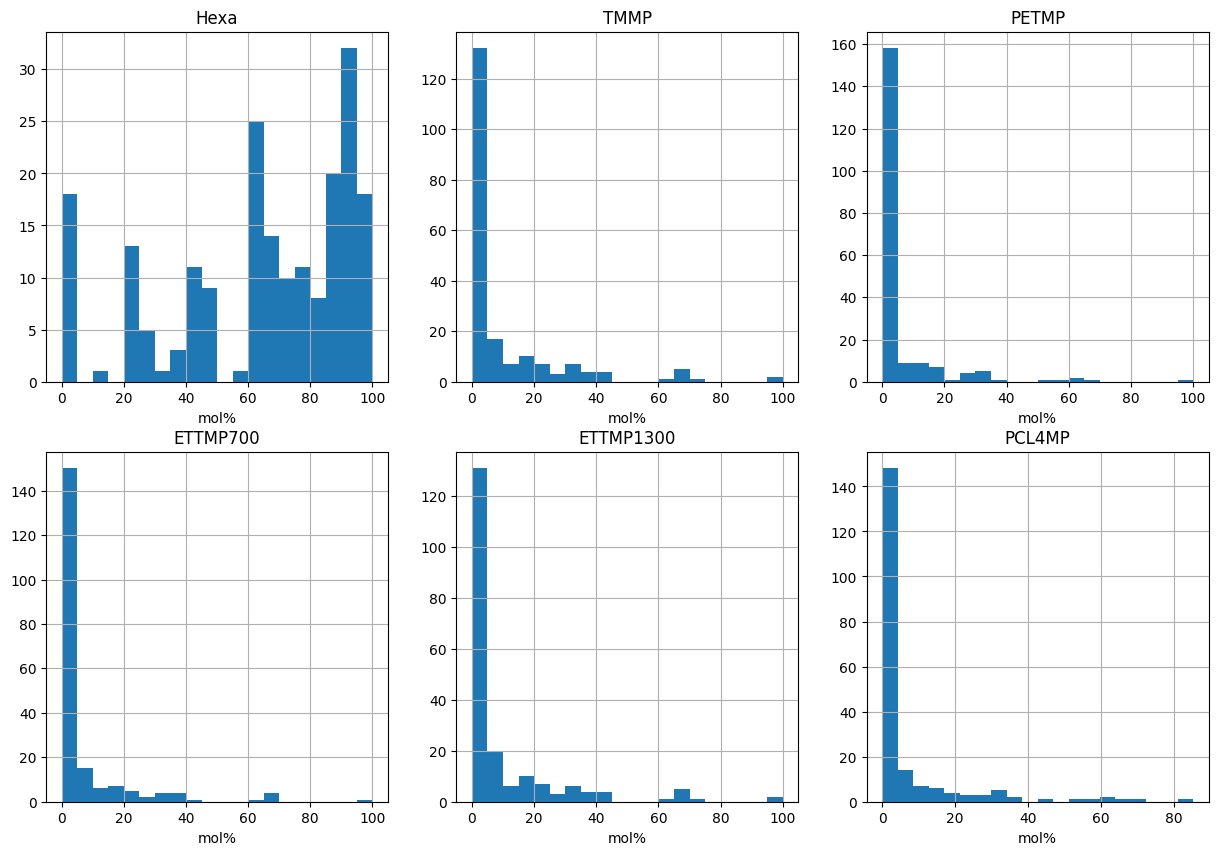

In [25]:
#check out the distribution of mol% values
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for i,col in enumerate(columns_new[:6]):
    ax = axs[i//3,i%3]
    polymer_df[col].hist(bins=20, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('mol%')


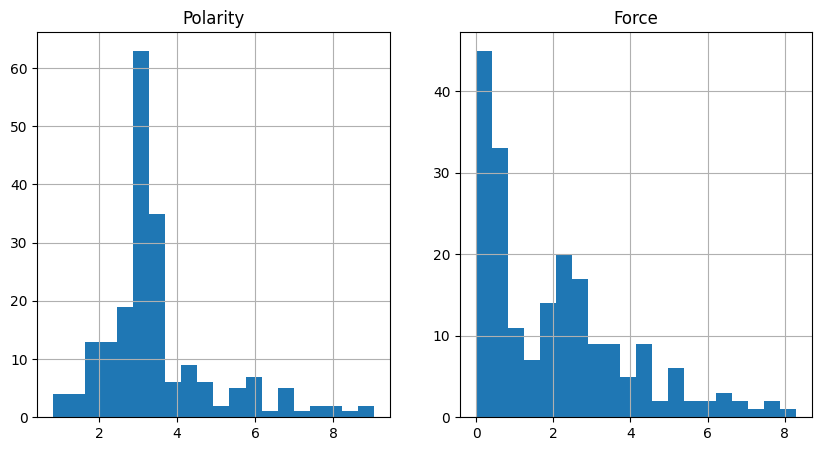

In [26]:
# and Polarity and force
fig, axs = plt.subplots(1,2, figsize=(10, 5))
for i,col in enumerate(columns_new[6:]):
    ax = axs[i]
    polymer_df[col].hist(bins=20, ax=ax)
    ax.set_title(col)

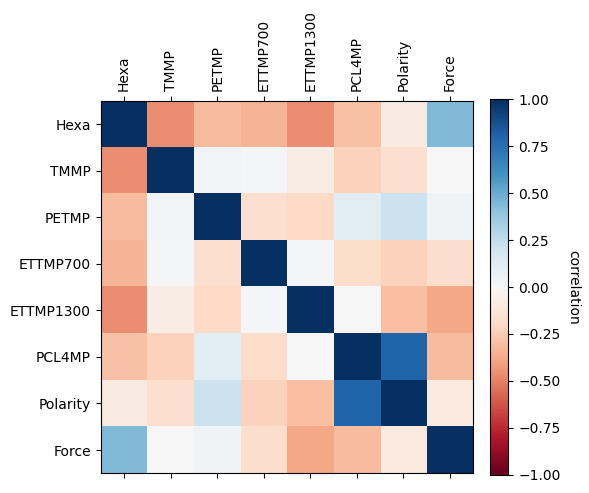

In [27]:
#normalize the data
scaler = MinMaxScaler()
polymer_df_norm = polymer_df.copy()
polymer_df_norm[columns_new] = scaler.fit_transform(polymer_df[columns_new])


#the correlation matrix
correlation = polymer_df_norm.corr()

#plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.matshow(correlation, cmap='RdBu', vmin=-1)

ax.set_xticks(np.arange(len(correlation)), labels=correlation.columns,rotation=90)
ax.set_yticks(np.arange(len(correlation)), labels=correlation.columns,rotation=0)

cbar = ax.figure.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('correlation', rotation=-90, va="bottom")

fig.tight_layout()
plt.show()

In [28]:
# Other possible features: N_thiol N_branch_long/short ??

In [29]:
# baseline model linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = polymer_df_norm[columns_new[:-1]]
y = polymer_df_norm[columns_new[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
train_error = mean_squared_error(y_train, lin_reg.predict(X_train))
test_error = mean_squared_error(y_test, y_pred)

print('Train error: ', train_error)
print('Test error: ', test_error)

Train error:  0.03366920391281606
Test error:  0.038225568037860355


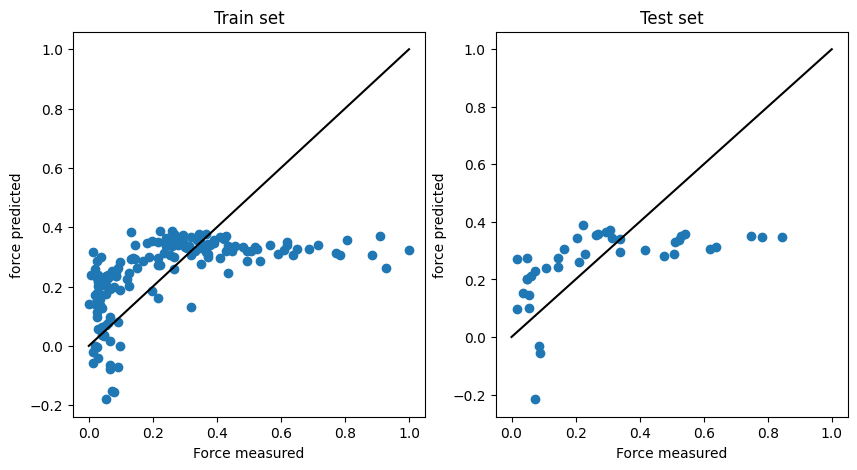

In [30]:
# plot the results
def set_labels(ax, xlabel = 'Force measured', ylabel='force predicted', title=''):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)



fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(y_train, lin_reg.predict(X_train), label='train')
ax[0].plot([0,1], [0,1], c = 'black')
set_labels(ax[0], title='Train set')

ax[1].scatter(y_test, y_pred, label='test')
ax[1].plot([0,1], [0,1], c = 'black')
set_labels(ax[1], title='Test set')

Far from ideal - also strong correlation between features. 

In [31]:
# pca analysis of the features
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_pca = pca.fit_transform(X)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Text(0, 0.5, 'Explained variance fraction')

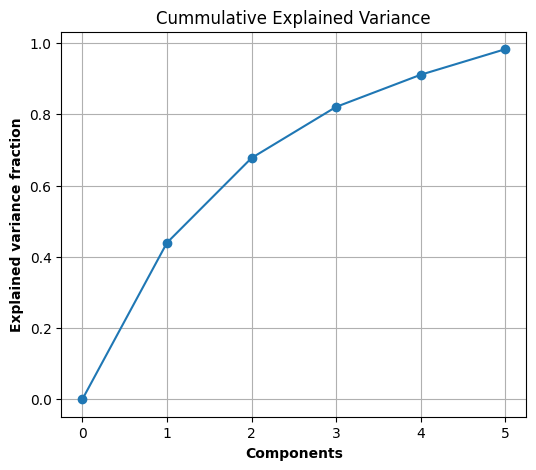

In [32]:
import numpy as np
#plot the cummulative variance
cv = np.cumsum(pca.explained_variance_ratio_)
grid = np.arange(1, pca.n_components_ + 1)

fig = plt.figure(figsize=(6,5))
ax1 = fig.subplots(1, 1)
ax1.plot(np.r_[0, grid], np.r_[0, cv], "o-")

ax1.grid()
ax1.set_title('Cummulative Explained Variance')
ax1.set_xlabel('Components', weight = 'bold')
ax1.set_ylabel('Explained variance fraction', weight = 'bold')

In [33]:
#Contributions of the different features to the components
component_names = ['PC'+ str(i) for i in range(1,pca.n_components_ +1)]
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names, 
    index=columns_new[:-1]
)
loadings

,PC1,PC2,PC3,PC4,PC5
Hexa,-0.899173,-0.012419,0.011440,-0.083034,-0.083349
TMMP,0.259787,-0.239970,-0.654827,-0.355566,-0.377995
PETMP,0.114643,0.161257,-0.221096,-0.034238,0.857450
ETTMP700,0.139150,-0.190840,0.022965,0.855412,-0.150661
ETTMP1300,0.260825,-0.227004,0.696359,-0.364729,-0.041461
PCL4MP,0.146333,0.596950,0.170250,-0.020929,-0.239242
Polarity,0.045266,0.686991,-0.088087,0.017628,-0.182477


#### Try a linear regression on the PCA

In [35]:
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_pca_train, y_train)

y_pred_a = lin_reg_pca.predict(X_pca_test)
train_error = mean_squared_error(y_train, lin_reg_pca.predict(X_pca_train))
test_error = mean_squared_error(y_test, y_pred_a)

print('Train error: ', train_error)
print('Test error: ', test_error)

Train error:  0.03471715914782814
Test error:  0.037543829494083455


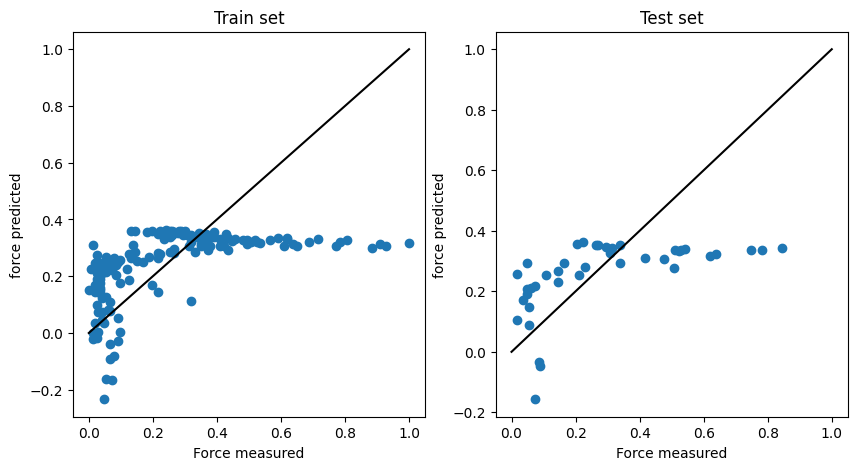

In [39]:
# plot the results
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(y_train, lin_reg_pca.predict(X_pca_train), label='train')
ax[0].plot([0,1], [0,1], c = 'black')
set_labels(ax[0], title='Train set')

ax[1].scatter(y_test, y_pred_a, label='test')
ax[1].plot([0,1], [0,1], c = 'black')
set_labels(ax[1], title='Test set')

In [40]:
y_pred[:10]

array([0.34848291, 0.3569755 , 0.37290472, 0.15389967, 0.22993559,
       0.2693488 , 0.31303304, 0.26042742, 0.20131534, 0.35009098])

In [41]:
y_pred_a[:10]

array([0.34417353, 0.35452157, 0.32643317, 0.17200579, 0.21915923,
       0.25711969, 0.32391697, 0.25360366, 0.20805957, 0.33631093])

Train error:  0.002861898640544803
Test error:  0.021971616436144797


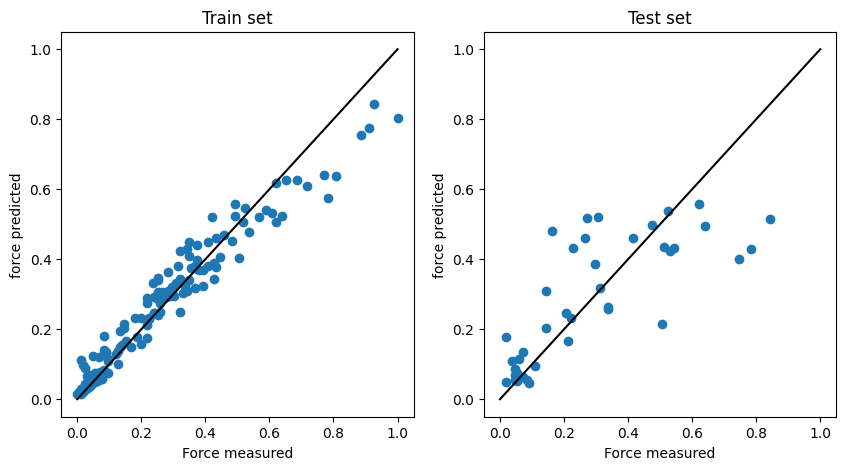

In [42]:
# fit a random forest regressor to X_train, y_train
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
y_pred_rf_train = rf_reg.predict(X_train)

train_error = mean_squared_error(y_train, y_pred_rf_train)
test_error = mean_squared_error(y_test, y_pred_rf)

print('Train error: ', train_error)
print('Test error: ', test_error)

# plot the results
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(y_train, y_pred_rf_train, label='train')
ax[0].plot([0,1], [0,1], c = 'black')
set_labels(ax[0], title='Train set')

ax[1].scatter(y_test, y_pred_rf, label='test')
ax[1].plot([0,1], [0,1], c = 'black')
set_labels(ax[1], title='Test set')

Train error:  0.012067440521290976
Test error:  0.03249727162866012


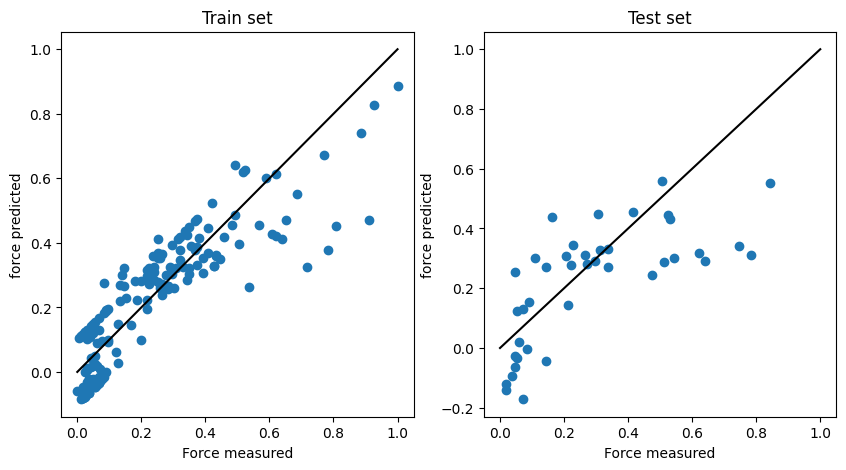

In [62]:
# a smv regressor
from sklearn.svm import SVR

svr_reg = SVR(kernel='rbf', C=100, gamma='scale', epsilon=.1)
svr_reg.fit(X_train, y_train)

y_pred_svr = svr_reg.predict(X_test)
y_pred_svr_train = svr_reg.predict(X_train)

train_error = mean_squared_error(y_train, y_pred_svr_train)
test_error = mean_squared_error(y_test, y_pred_svr)

print('Train error: ', train_error)
print('Test error: ', test_error)

# plot the results
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(y_train, y_pred_svr_train, label='train')
ax[0].plot([0,1], [0,1], c = 'black')
set_labels(ax[0], title='Train set')

ax[1].scatter(y_test, y_pred_svr, label='test')
ax[1].plot([0,1], [0,1], c = 'black')
set_labels(ax[1], title='Test set')
